## MNISTの生成(RCGAN)

In [124]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [133]:
from keras.layers import Input, Dense, Reshape, concatenate, Flatten, Embedding, RepeatVector
from keras.layers.recurrent import LSTM
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam, SGD

In [134]:
class RCGAN():
    def __init__(self,
                 batch_size,
                 input_dim,
                 latent_dim,
                 hidden_dim,
                 embed_dim,
                 sequence,
                 labels,
                 summary=False,
                 save_image=False,
                 save_model=False,
                 gen_data=False,
                 dataset='sin_wave'):

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim
        self.sequence = sequence
        self.batch_size = batch_size
        self.labels = labels
        self.summary = summary
        self.save_image = save_image
        self.save_model = save_model
        self.gen_data = gen_data
        self.dataset = dataset

        # optimizer = RMSprop()
        g_optimizer = RMSprop()
        d_optimizer = RMSprop()
        # g_optimizer = Adam(lr=0.1)
        # d_optimizer = SGD(lr=0.1)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=d_optimizer,
                                   metrics=['accuracy'])
        if self.summary:
            print('** discriminator model *****')
            self.discriminator.summary()

        # Build the generator
        self.generator = self.build_generator()
        
        if self.summary:
            print('** generator model *****')
            self.generator.summary()

        # The generator takes noise as input and generates data
        z = Input(shape=(self.sequence, self.latent_dim))
        # conditional input
#         cond = Input(shape=(self.sequence, self.labels))
        cond = Input(shape=(1, ))
        gen = self.generator([z, cond])

        # For the combined model we will only train the generator
        self.set_trainable(self.discriminator, trainable=False)

        # The discriminator takes generated data as input and validate
        validity = self.discriminator([gen, cond])

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([z, cond], validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=g_optimizer)
        
        if self.summary:
            print('** combined model *****')
            self.combined.summary()

    def build_generator(self):

        model = Sequential()

        model.add(LSTM(units=self.hidden_dim,
                       batch_input_shape=(
                           None, self.sequence, self.latent_dim + self.embed_dim),
                       return_sequences=True))
        model.add(Dense(self.input_dim, activation='tanh'))

        noise = Input(shape=(self.sequence, self.latent_dim),
                      name='g_noise_input')
        # conditional input
#         cond = Input(shape=(self.sequence, self.labels), name='g_cond_input')
        cond = Input(shape=(1, ), name='g_cond_input')
        cond_emb = Flatten()(Embedding(self.labels, self.embed_dim)(cond))
        cond_emb = RepeatVector(self.sequence)(cond_emb) 
        cond_input = concatenate([noise, cond_emb], axis=-1)
        gen_x = model(cond_input)

        return Model([noise, cond], gen_x)

    def build_discriminator(self):

        model = Sequential()

        model.add(LSTM(units=self.hidden_dim,
                       batch_input_shape=(None, self.sequence,
                                          self.input_dim + self.embed_dim),
                       return_sequences=True))
        model.add(Dense(self.input_dim, activation='sigmoid'))

        inputs = Input(shape=(self.sequence, self.input_dim), name='d_input')
#         cond = Input(shape=(self.sequence, self.labels), name='d_cond_input')
        cond = Input(shape=(1, ), name='d_cond_input')
        cond_emb = Flatten()(Embedding(self.labels, self.embed_dim)(cond))
        cond_emb = RepeatVector(self.sequence)(cond_emb) 
        cond_input = concatenate([inputs, cond_emb], axis=-1)
        validity = model(cond_input)

        return Model([inputs, cond], validity)

    def set_trainable(self, model, trainable=False):
        model.trainable = trainable
        for layer in model.layers:
            layer.trainable = trainable

    def save_models(self):
        model_json_str = self.generator.to_json()
        open('models/' + self.dataset + '_generator_model.json', 'w') \
            .write(model_json_str)
        self.generator.save_weights('models/' + self.dataset + '_generator_weight.h5')
        model_json_str = self.discriminator.to_json()
        open('models/' + self.dataset + '_discriminator_model.json', 'w') \
            .write(model_json_str)
        self.generator.save_weights('models/' + self.dataset + '_discriminator_weight.h5')

    def train(self, n_epochs, x_train, y_train, x_eval, y_eval):

        # Adversarial ground truths
        valid = np.ones((self.batch_size, self.sequence, self.input_dim))
        fake = np.zeros((self.batch_size, self.sequence, self.input_dim))

        for epoch in range(n_epochs):

            g_loss = []
            d_loss = []
            acc = []
            best_mmd2 = 999

            # shuffle
            rnd = np.random.randint(999)
            for l in [x_train, y_train]:
                np.random.seed(rnd)
                np.random.shuffle(l)

            for i in range(int(x_train.shape[0] / self.batch_size)):
                # Select a random batch of
                x = x_train[i * self.batch_size: (i + 1) * self.batch_size]
                y = y_train[i * self.batch_size: (i + 1) * self.batch_size]
                # Repeat cond sequence
#                 y = np.stack([y] * self.sequence, axis=1)

                noise = np.random.normal(0, 1, (
                    self.batch_size, self.sequence, self.latent_dim))

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Generate a batch of new images
                gen_x = self.generator.predict([noise, y])
                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch([x, y], valid)
                d_loss_fake = self.discriminator.train_on_batch([gen_x, y],
                                                                fake)
                _d_loss, _acc = 0.5 * np.add(d_loss_real, d_loss_fake)
                d_loss.append(_d_loss)
                acc.append(_acc)

                # ---------------------
                #  Train Generator
                # ---------------------

                noise = np.random.normal(0, 1, (
                    self.batch_size, self.sequence, self.latent_dim))

                # # Condition on random labels
                # sampled_cond = np.random.randint(0,
                #                                  self.labels,
                #                                  (self.batch_size,
                #                                   self.labels))
                # sampled_cond = np.stack([sampled_cond] * self.sequence, axis=1)

                # Train the generator
                _g_loss = self.combined.train_on_batch([noise, y],
                                                       valid)
                g_loss.append(_g_loss)

            # calculate maximum mean discrepancy
#             eval_size = x_eval.shape[0]
#             noise = np.random.normal(0, 1,
#                                      (eval_size, self.sequence,
#                                       self.latent_dim))
            # sampled_cond = np.random.randint(0,
            #                                  self.labels,
            #                                  (eval_size,
            #                                   self.labels))
            # Repeat cond by sequence
            # sampled_cond = np.stack([sampled_cond] * self.sequence, axis=1)
#             _y_eval = np.stack([y_eval] * self.sequence, axis=1)
#             eval_gan = self.generator.predict([noise, _y_eval])

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (
                epoch + 1,
                np.mean(d_loss),
                100 * np.mean(acc),
                np.mean(g_loss)))

In [173]:
# load MNIST data
(X_train, y_train), (X_eval, y_eval) = mnist.load_data()
X_train = X_train.astype('float32')
X_eval = X_eval.astype('float32')
print('train shape: ', X_train.shape)
print('eval shape: ', X_eval.shape)
# scale samples from 0 to 1
X_train /= 255
X_eval /= 255
# scale from -1 to 1
X_train = 2 * X_train - 1
X_eval = 2 * X_eval - 1
# hyper parameter for training
sequence = X_train.shape[1]
input_dim = X_train.shape[2]
latent_dim = 50
hidden_dim = 100
embed_dim = 10
batch_size = 64
n_epochs = 100
labels = 10

train shape:  (60000, 28, 28)
eval shape:  (10000, 28, 28)


In [138]:
rcgan = RCGAN(batch_size,
            input_dim,
            latent_dim,
            hidden_dim,
            embed_dim,
            sequence,
            labels,
            summary=True,
            dataset='mnist')

** discriminator model *****
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
d_cond_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, 1, 10)        100         d_cond_input[0][0]               
__________________________________________________________________________________________________
flatten_48 (Flatten)            (None, 10)           0           embedding_56[0][0]               
__________________________________________________________________________________________________
d_input (InputLayer)            (None, 28, 28)       0                                            
________________________________________________________________________________

In [139]:
rcgan.train(n_epochs, X_train, y_train, _, _)

/root/anaconda2/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.396295, acc.: 80.54%] [G loss: 3.228863]
2 [D loss: 0.245929, acc.: 86.79%] [G loss: 3.768872]
3 [D loss: 0.325029, acc.: 81.66%] [G loss: 3.206583]
4 [D loss: 0.498042, acc.: 71.16%] [G loss: 1.939985]
5 [D loss: 0.478526, acc.: 71.60%] [G loss: 1.977572]
6 [D loss: 0.489380, acc.: 70.77%] [G loss: 1.866413]
7 [D loss: 0.530008, acc.: 68.29%] [G loss: 1.608053]
8 [D loss: 0.584661, acc.: 64.43%] [G loss: 1.291465]
9 [D loss: 0.609905, acc.: 62.19%] [G loss: 1.139292]
10 [D loss: 0.620131, acc.: 61.28%] [G loss: 1.081035]
11 [D loss: 0.625001, acc.: 60.87%] [G loss: 1.054944]
12 [D loss: 0.628830, acc.: 60.45%] [G loss: 1.034595]
13 [D loss: 0.632701, acc.: 60.30%] [G loss: 1.011017]
14 [D loss: 0.630618, acc.: 60.49%] [G loss: 1.016513]
15 [D loss: 0.632414, acc.: 60.36%] [G loss: 1.013855]
16 [D loss: 0.628591, acc.: 60.84%] [G loss: 1.018595]
17 [D loss: 0.631409, acc.: 60.47%] [G loss: 1.011372]
18 [D loss: 0.629025, acc.: 60.78%] [G loss: 1.014184]
19 [D loss: 0.62745

## 元の画像
---

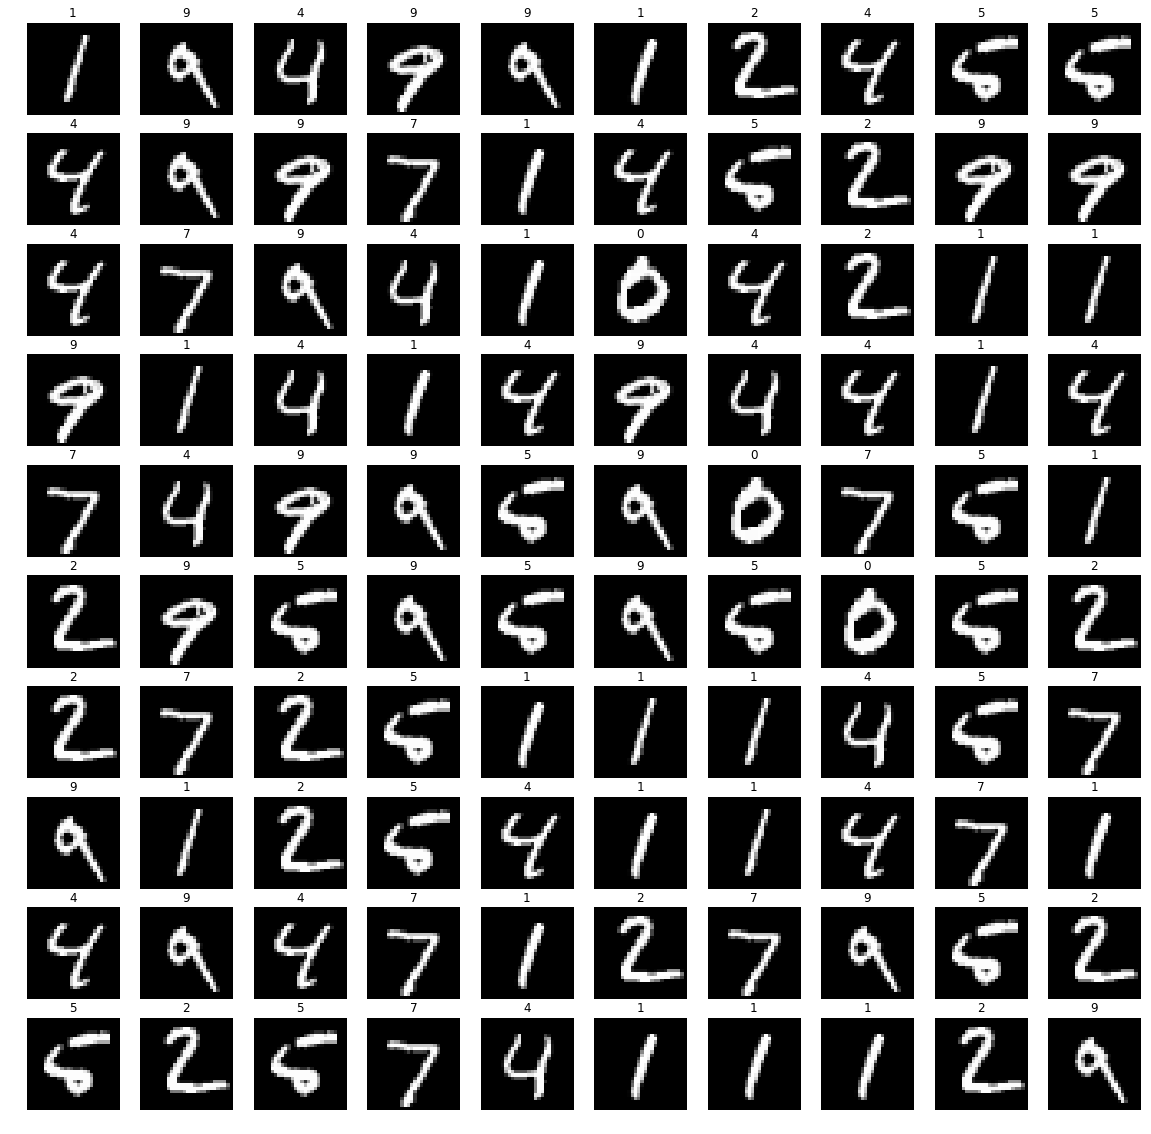

In [168]:
sample_size = 100

idxes = np.random.randint(0, labels, sample_size)

plt.figure(figsize=(20, 20))
# show sin wave
for i in range(sample_size):
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.title(y_eval[idxes[i]])
    plt.imshow(X_eval[idxes[i]], cmap='gray')

## 学習済のモデルでの画像復元
---

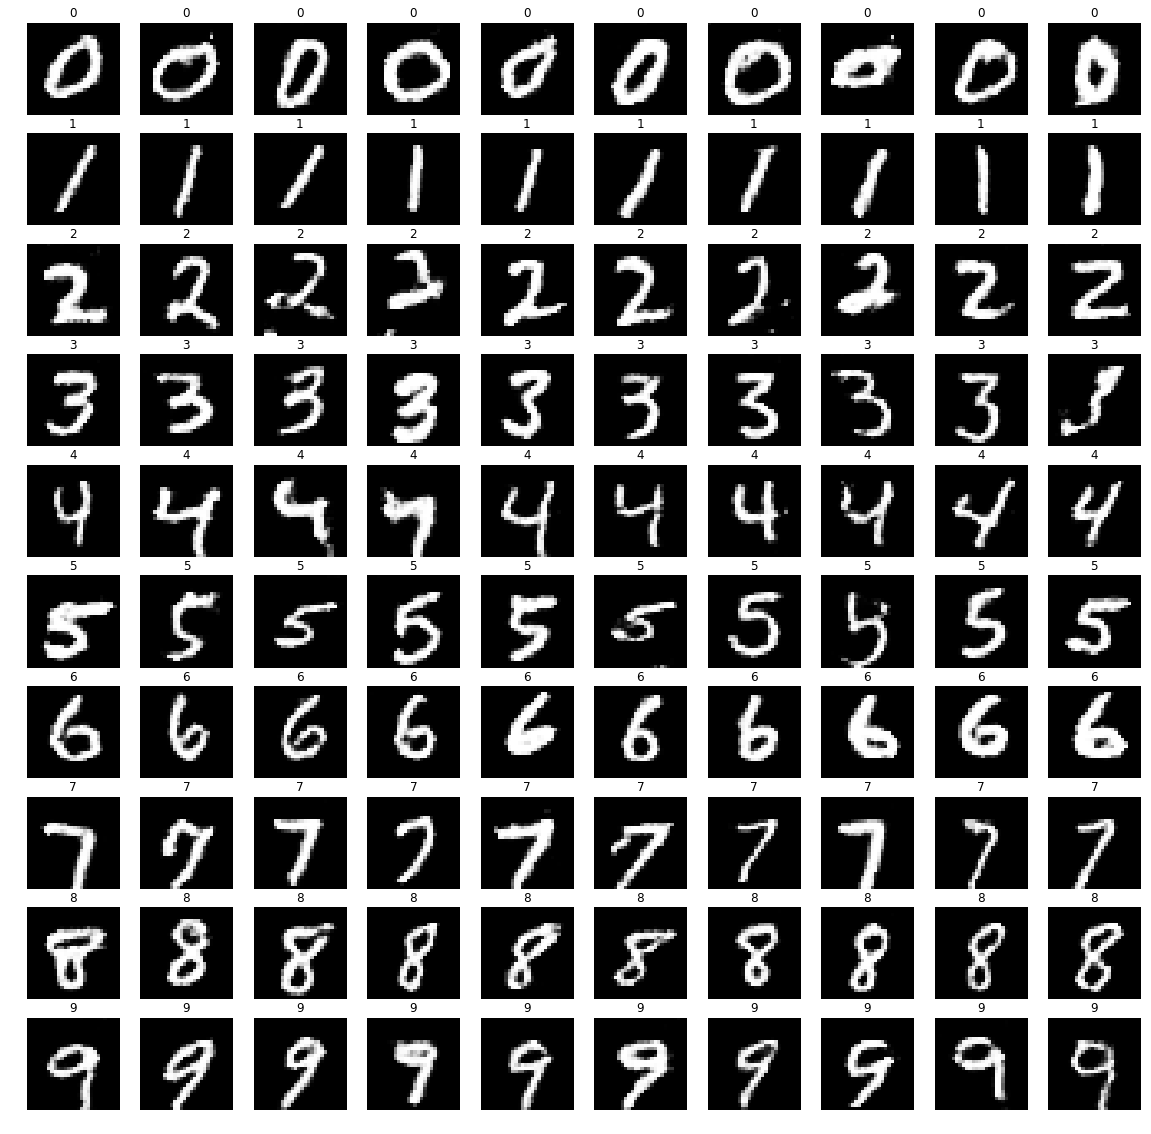

In [169]:
def generate_mnist(generator, show_seq, sample_size=100):
    noise = np.random.normal(0, 1, (sample_size, sequence, latent_dim))
    cond = show_seq
    gen_mnist = generator.predict([noise, cond])
    return np.squeeze(gen_mnist)

show_seq = np.sort(np.tile(np.arange(labels), labels))
gen_mnist_sample = generate_mnist(rcgan.generator, show_seq)
plt.figure(figsize=(20, 20))

for i, digit in enumerate(show_seq):
    plt.subplot(10, 10, i + 1)
    plt.axis('off')
    plt.title(digit)
    plt.imshow(gen_mnist_sample[i], cmap='gray')

In [171]:
# generate synthetic data
data_num = 10000
synthetic_y = np.random.randint(0, labels, data_num)
synthetic_x = generate_mnist(rcgan.generator, synthetic_y, data_num)
synthetic_x = np.expand_dims(synthetic_x, axis=2)
np.savez('synthetic_data', x=synthetic_x, y=synthetic_y)

In [175]:
# true data
eval_samples = 1000
idxes = np.random.randint(0, X_eval.shape[0], eval_samples)
X_eval = X_eval[idxes]
y_eval = y_eval[idxes]
np.savez('true_data', x=X_eval, y=X_eval)